<a href="https://colab.research.google.com/github/arminwitte/llsi/blob/notebooks/notebooks/example_diss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install llsi

In [ ]:
!wget https://github.com/arminwitte/llsi/blob/80150bc50595bbd6ba2e06b351b0c439b023c867/data/heated_wire_data.npy

--2024-09-07 18:58:45--  https://github.com/arminwitte/llsi/blob/80150bc50595bbd6ba2e06b351b0c439b023c867/data/heated_wire_data.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘heated_wire_data.npy.1’

heated_wire_data.np     [ <=>                ] 293.51K  1.61MB/s    in 0.2s    

2024-09-07 18:58:45 (1.61 MB/s) - ‘heated_wire_data.npy.1’ saved [300553]



In [ ]:


import numpy as np

d = np.load("heated_wire_data.npy")

import llsi

In [ ]:
t = d[:, 0]
Re = d[:, 1]
Nu = d[:, 2]

(305002,)
Splitting at 13556
239.9995820843808
0.00525693
 0.0247895
 0.0327177
 0.0519246
    1e+300
 0.0413317
  0.366388
   1.24543
  0.856283
1.79769e+308
  0.495445
1.35553e+19
  0.255517
   2.09684
  0.172722
  0.885819
  0.116739
  0.296326
 0.0752711
  0.154585
 0.0502962
 0.0686183
 0.0117917
 0.0441935
  0.176459
 0.0130791
 0.0365888
  0.119788
 0.0124107
 0.0568603
 0.0095973
 0.0319461
 0.0116775
 0.0483848
0.00687294
 0.0166468
 0.0071026
 0.0151015
0.00679617
 0.0194165
0.00546887
0.00823609
  0.009745
0.00559893
0.00981899
0.00510261
 0.0114929
0.00480168
0.00879231
0.00484533
 0.0101808
0.00480978
0.00562454
0.00474007
0.00443428
0.00549543
 0.0053117
0.00452702
0.00589768
0.00442972
0.00578104
0.00437247
0.00451541
0.00544012
0.00438028
0.00434184
0.00491576
0.00437682
0.00449973
0.00429904
0.00469218
0.00426104
 0.0045021
 0.0042744
0.00444746
0.00426434
0.00430822
0.00420465
0.00434307
0.00463579
 0.0042117
  0.004472
0.00421797
0.00420699
0.00419907
 0.0042926
0.00

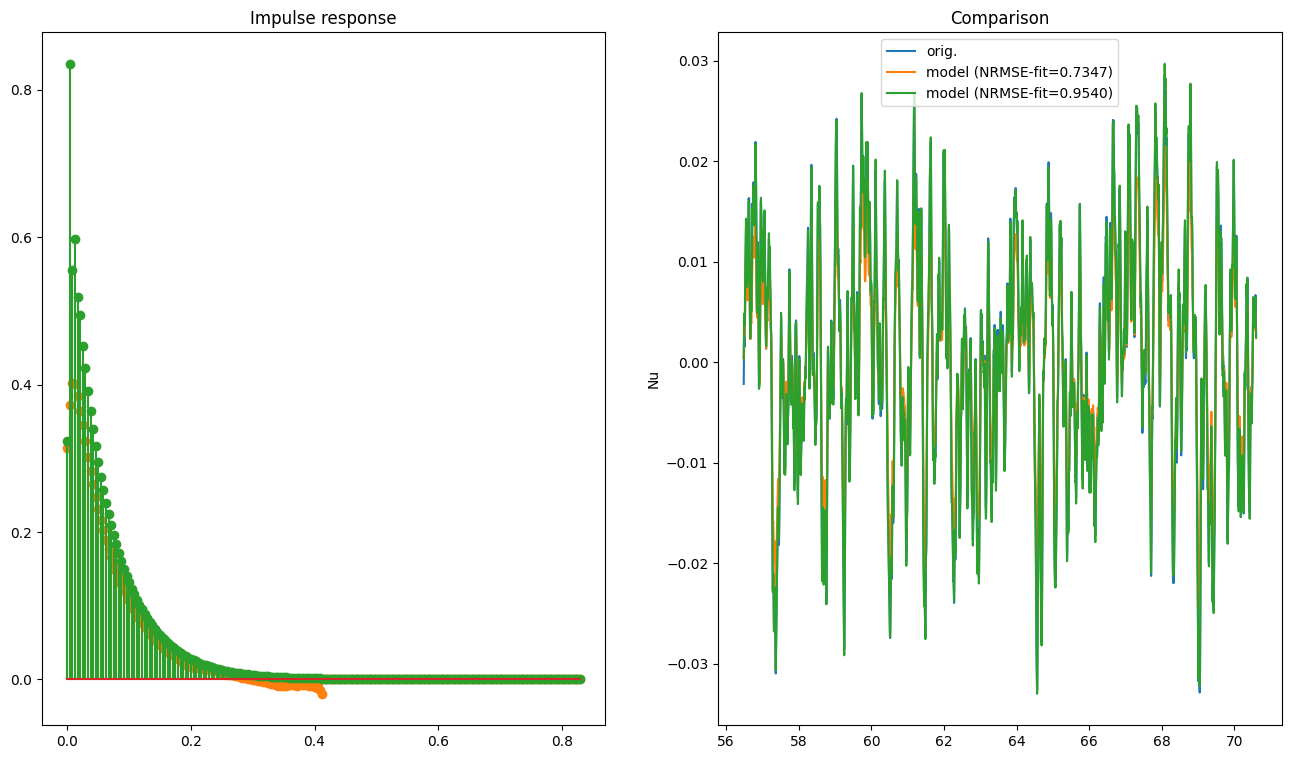

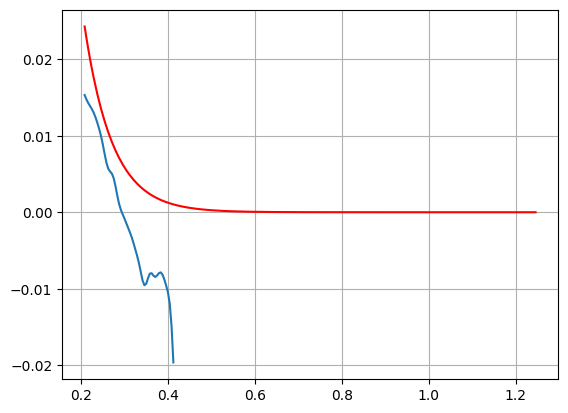

In [8]:

data = llsi.SysIdData(t=t, Re=Re, Nu=Nu)
data.equidistant(305002)
print(data.time().shape)
data.center()
data.downsample(18)
data.lowpass(1, 10)
data, test_set = data.split(0.8)
data.crop(start=1000)
data.center()
print(1 / data.Ts)

import matplotlib.pyplot as plt

with llsi.Figure() as fig:
    mod1 = llsi.sysid(
        data, "Nu", "Re", (0, 100, 0), method="arx", settings={"lambda": 1e2}
    )
    mod2 = llsi.sysid(
        data, "Nu", "Re", (3, 3, 0), method="pem", settings={"init": "arx"}
    )
    fig.plot([mod1, mod2], "impulse")
    fig.plot(
        {"mod": [mod1, mod2], "data": test_set, "y_name": "Nu", "u_name": "Re"},
        "compare",
    )

if False:
    import scipy

    t, y = scipy.signal.dimpulse(mod1.to_ss())

    fig, ax = plt.subplots()
    plt.plot(t, np.squeeze(y))
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.impulse(mod1.to_ss(continuous=True))

    # fig, ax = plt.subplots()
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.impulse(mod1.to_ss(continuous=True, method="euler"))

    # fig, ax = plt.subplots()
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.dimpulse(mod1.to_tf())
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.dimpulse(mod1.to_zpk())
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    plt.legend(["discrete", "cont", "euler", "tf", "zpk"])


fig, ax = plt.subplots()
ti1, i1 = mod1.impulse_response()
ti2, i2 = mod2.impulse_response(300)
plt.plot(ti1[50:], i1[50:])
plt.plot(ti2[50:], i2[50:], "r")
plt.grid(True)

print(i1[:5])
# print(i2[:5])